In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt; plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import librosa
import numpy as np
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import tqdm
import itertools
import scipy.stats
import random
%matplotlib inline

import identification.dataset

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'src'

In [2]:
config = {
    'frame_size': 2048,
    'hop_ratio': 1,
    'n_coeff': 100,
    'sr': 10000,
    'sample_duration': 30,
    'feature': 'MFCC_welch',
    # 'clf': sklearn.neighbors.KNeighborsClassifier(),
    # 'clf__n_neighbors': 9,
    # 'clf__p': 1,
    # 'clf__weights': 'distance',
    'clf': sklearn.svm.SVC(),
    'clf__decision_function_shape': 'ovr',
    'clf__kernel': 'linear',
    'clf__C': 1.0,
}

In [4]:
# data = pd.read_pickle('../data/processed/dataset_bilbao.pkl')
# data = data[data.type.isin(['free', 'scale']) & (data.player != 15)]

data = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
data = data[(data.violin.isin(['A', 'B', 'C']))]
features = get_dataset(config, data)

100%|██████████| 1183/1183 [00:36<00:00, 32.33it/s]


In [5]:
train_df, test_df = sklearn.model_selection.train_test_split(features, test_size=0.2)
# train_df = features[features.type == 'scale']
# test_df = features[features.type == 'free']

In [6]:
def train(config, train_df, test_df):
    # Test / Train
    x_train = np.vstack(train_df.features)
    y_train = train_df.violin.to_numpy()
    x_test = np.vstack(test_df.features)
    y_test = test_df.violin.to_numpy()

    # Train
    estimator = config['clf']
    pipeline = sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('clf', estimator),
    ])
    valid_params = pipeline.get_params()
    params = {x:config[x] for x in config if x in valid_params}
    pipeline.set_params(**params)
    pipeline.fit(x_train, y_train)
    return pipeline.score(x_test, y_test)

In [ ]:
names = list(set(data.player))

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

scores = []

# @interact(n=(1,101,2))
@interact(kernel=['linear','poly', 'rbf', 'sigmoid'], C=(0.1,1.0,0.1))
def train_plot(kernel='linear', C=1.0):
    global scores
    scores = []
    # config['clf__n_neighbors'] = n
    config['clf__kernel'] = kernel
    config['clf__C'] = C
    for i in range(3, len(names)):
    # for i in tqdm.tqdm(range(2, len(names))):
        # subsets = list(itertools.combinations(names, i))
        # random.shuffle(subsets)
        # for subset in subsets[:30]:
        for _ in range(100):
            subset = random_combination(names, i)
            train_dff = train_df[train_df.player.isin(list(subset))]
            if len(train_dff) < 250:
                continue
            score = train(config, train_dff[:250], test_df)
            scores.append({'score': score, 'n': i})
    scores = pd.DataFrame.from_dict(scores)

    fig, ax = plt.subplots()
    stats = scores.groupby('n')['score'].agg(['mean', 'std']).reset_index()
    ax.errorbar(x='n', y='mean', yerr='std', data=stats, fmt='o--')
    # plt.plot('n', 'score', '.', data=scores)
    # ax.set_xlabel('Nombre de personnes dans $x_{train}$')
    # ax.set_ylabel('Précision (\\%)')
    # plt.show()

## Visualization

In [ ]:
fig, ax = plt.subplots()
stats = scores.groupby('n')['score'].agg(['mean', 'std']).reset_index()
ax.errorbar(x='n', y='mean', yerr='std', data=stats, fmt='o--')
# plt.plot('n', 'score', '.', data=scores)
ax.set_xlabel('Nombre de personnes dans $x_{train}$')
ax.set_ylabel('Précision (\\%)')
plt.show()

In [ ]:
fig, ax = plt.subplots()

n_points = 1000
overlap = 0.9
scale = 200

xs = []
y = np.linspace(
    scores['score'].min(),
    scores['score'].max(),
    n_points
)

# for i in scores['n'].unique():
#     pdf = scipy.stats.gaussian_kde(scores[scores['n'] == i].score)
#     x = i * (1 - overlap)
#     xs.append(x)
#     ax.fill_betweenx(
#         y*100, 
#         np.ones(n_points) * x,
#         pdf(y)/scale + x,
#         alpha=.9,
#         zorder=-i,
#         color=mpl.colormaps['viridis'](i/len(scores['n'].unique()))
#     )
#     ax.plot(
#         pdf(y)/scale + x,
#         y*100,
#         c='k',
#         linewidth=1
#     )
sns.violinplot(x='n', y='score', data=scores)
# ax.set_xticks(xs, scores['n'].unique())
# plt.plot(xs, 'mean', 'r--', data=stats)
ax.set_xlabel('Number of players $n$ in the training data')
ax.set_ylabel('Precision distribution (\\%)')
# ax.set_ylim([0.45,1])
plt.tight_layout()
plt.savefig('../reports/figures/precision_bilbao.png', dpi=600)
plt.show()

In [31]:
extracts = list(set(data.extract))
extracts.remove('?')

# @interact(n=(1,101,10))
@interact(kernel=['linear','poly', 'rbf', 'sigmoid'], C=(0.1,1.0,0.1))
def train_plot_extract(n=11, kernel='linear', C=0.9):
    config['clf__n_neighbors'] = n
    config['clf__C'] = C
    global scores
    scores = []
    
    for kernel in ['linear','poly', 'rbf', 'sigmoid']:
        config['clf__kernel'] = kernel
        for i in range(len(extracts)):
            for split in range(100):
                train_df, test_df = sklearn.model_selection.train_test_split(features, test_size=0.2)
                train_dff = train_df[train_df.extract == extracts[i]]
                score = train(config, train_dff[:100], test_df)
                scores.append({'score': score, 'extract': extracts[i]})
    scores = pd.DataFrame.from_dict(scores)
    
    fig, ax = plt.subplots()
    scores.replace('tchai', 'Tchaikovsky', inplace=True)
    scores.replace('gamme', 'Scale', inplace=True)
    scores.replace('mozart', 'Mozart', inplace=True)
    scores.replace('glazounov', 'Glazounov', inplace=True)
    scores.replace('bach', 'Bach', inplace=True)
    scores.replace('sibelius', 'Sibelius', inplace=True)
    scores.replace('free', 'Free', inplace=True)

    order = scores.groupby(by=['extract'])['score'].median().sort_values().index

    sns.violinplot(x='extract', y='score', data=scores, order=order)
    ax.set_xlabel('Recording used in the training data')
    ax.set_ylabel('Model precision')
    ax.tick_params(axis='x', rotation=30)
    plt.show()

interactive(children=(IntSlider(value=11, description='n', max=33, min=-11), Dropdown(description='kernel', op…

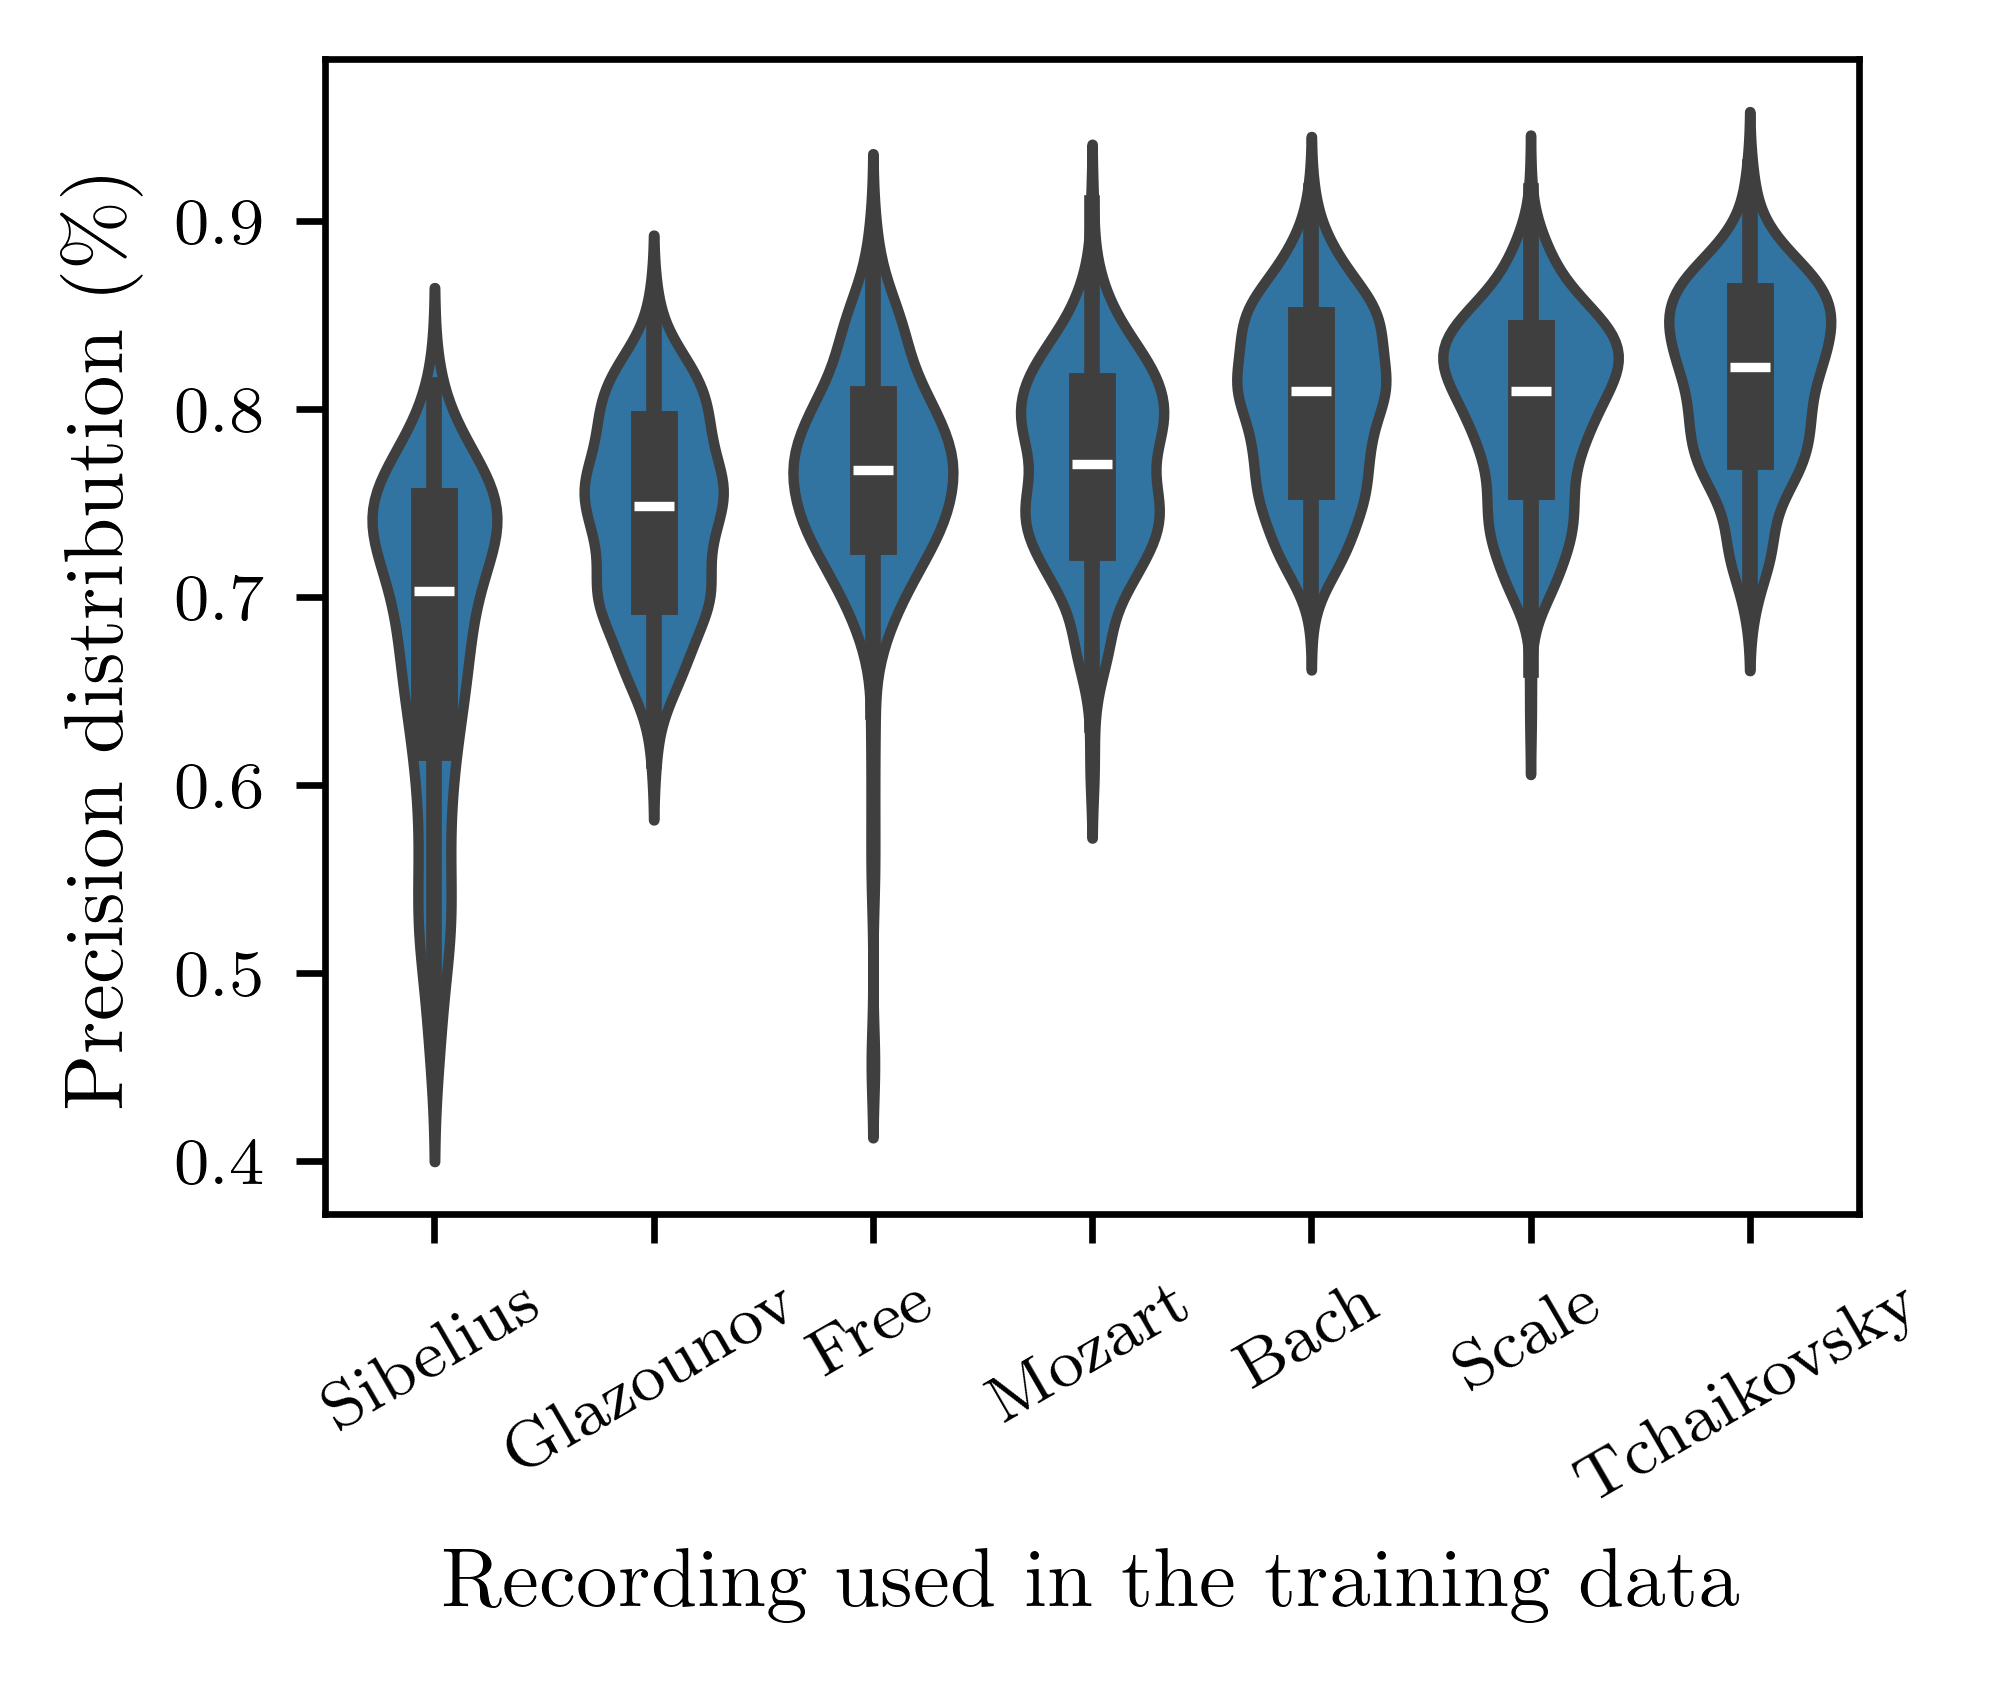

In [32]:
fig, ax = plt.subplots()

scores.replace('tchai', 'Tchaikovsky', inplace=True)
scores.replace('gamme', 'Scale', inplace=True)
scores.replace('mozart', 'Mozart', inplace=True)
scores.replace('glazounov', 'Glazounov', inplace=True)
scores.replace('bach', 'Bach', inplace=True)
scores.replace('sibelius', 'Sibelius', inplace=True)
scores.replace('free', 'Free', inplace=True)

order = scores.groupby(by=['extract'])['score'].median().sort_values().index

sns.violinplot(x='extract', y='score', data=scores, order=order)
ax.set_xlabel('Recording used in the training data')
ax.set_ylabel('Precision distribution (\\%)')
ax.tick_params(axis='x', rotation=30)
plt.savefig('../reports/figures/precision-vs-extract.png', dpi=600, bbox_inches='tight')